In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import streamlit as st
from PIL import Image
import PIL.ImageEnhance as ImageEnhance
from PIL import ImageFilter

In [48]:
def enhance_magic_color(cv_img):
    """Magic color: contrast + saturation + local sharpening"""
    pil = Image.fromarray(cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB))
    # increase contrast
    pil = ImageEnhance.Contrast(pil).enhance(1.2)
    # increase color
    pil = ImageEnhance.Color(pil).enhance(2.15)
    # slight sharpness
    pil = ImageEnhance.Sharpness(pil).enhance(6.1)
    # optional slight unsharp mask (PIL filter)
    pil = pil.filter(ImageFilter.UnsharpMask(radius=1, percent=200, threshold=5))
    return cv2.cvtColor(np.array(pil), cv2.COLOR_RGB2BGR)

In [49]:
img = cv2.imread('Coba2/20251013_154318.jpg', cv2.IMREAD_COLOR)

(np.float64(-0.5), np.float64(2999.5), np.float64(3999.5), np.float64(-0.5))

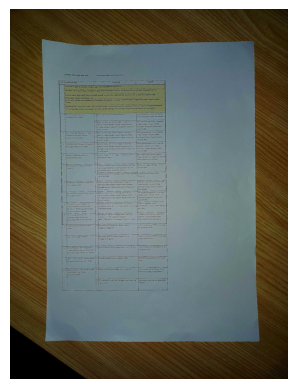

In [50]:
enhance_magic_color(img)
plt.imshow(cv2.cvtColor(enhance_magic_color(img), cv2.COLOR_BGR2RGB))
plt.axis('off')

In [19]:
# Resize image to workable size
dim_limit = 1080
max_dim = max(img.shape)
if max_dim > dim_limit:
    resize_scale = dim_limit / max_dim
    img = cv2.resize(img, None, fx=resize_scale, fy=resize_scale)

# Making Copy of original image.
orig_img = img.copy()

In [20]:
# Repeated Closing operation to remove text from the document.
kernel = np.ones((9,9),np.uint8)
img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations= 3)

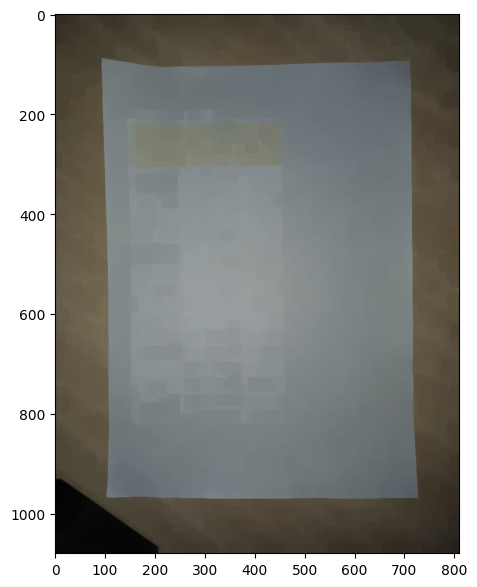

In [21]:
plt.figure(figsize = (10,7))
plt.imshow(img[:,:,::-1])
plt.show()

In [22]:
# --- 2️⃣ Siapkan mask & model (otomatis mencari rect kertas) ---
mask = np.zeros(img.shape[:2], np.uint8)
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

# --- 3️⃣ Otomatis deteksi perkiraan area kertas (bounding box dari kontur terbesar) ---
gray_tmp = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# gunakan blur untuk meredam noise
gray_blur = cv2.GaussianBlur(gray_tmp, (5,5), 0)

# threshold adaptif atau Otsu (coba Otsu dulu)
_, th_ot = cv2.threshold(gray_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# Pastikan kertas biasanya terang -> jika kertas gelap terhadap latar, invert jika perlu
# Kita periksa apakah area putih dominan, jika tidak, invert threshold
if np.sum(th_ot == 255) < np.sum(th_ot == 0):
    th = cv2.bitwise_not(th_ot)
else:
    th = th_ot

# small morphology to connect paper region
kernel_small = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel_small, iterations=2)
th = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel_small, iterations=1)

# find contours and choose the largest plausible paper contour
contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
rect = None
h_img, w_img = img.shape[:2]
if contours:
    # filter by area: minimal area threshold (e.g. 1% of image)
    min_area = 0.01 * (w_img * h_img)
    contours = [c for c in contours if cv2.contourArea(c) > min_area]
    if contours:
        largest = max(contours, key=cv2.contourArea)
        x,y,w,h = cv2.boundingRect(largest)
        # add relative margin so GrabCut has some background context
        mx = int(w * 0.05)
        my = int(h * 0.05)
        x1 = max(0, x - mx)
        y1 = max(0, y - my)
        x2 = min(w_img, x + w + mx)
        y2 = min(h_img, y + h + my)
        rect = (x1, y1, x2 - x1, y2 - y1)

# fallback: jika tidak ketemu kontur yang valid, gunakan rect penuh minus margin kecil
if rect is None:
    margin = int(min(w_img, h_img) * 0.03)
    rect = (margin, margin, w_img - 2*margin, h_img - 2*margin)

# --- 4️⃣ Jalankan GrabCut dengan rect otomatis ---
# 
# pastikan rect punya ukuran yang masuk akal
rx, ry, rw, rh = rect
if rw < 10 or rh < 10:
    print(f"⚠️ Rect terlalu kecil, gunakan fallback penuh.")
    margin = int(min(img.shape[:2]) * 0.03)
    rect = (margin, margin, img.shape[1]-2*margin, img.shape[0]-2*margin)

try:
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
except cv2.error as e:
    print(f"⚠️ GrabCut gagal di {rect}, fallback ke rect penuh.")
    # fallback ke rect penuh
    rect = (10, 10, img.shape[1]-20, img.shape[0]-20)
    mask[:] = 0
    bgdModel[:] = 0
    fgdModel[:] = 0
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

# --- 5️⃣ Buat mask biner untuk area foreground (kertas) ---
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

# --- 6️⃣ Perbaikan mask: hilangkan noise & ratakan tepi ---
kernel = np.ones((5,5), np.uint8)
mask2 = cv2.morphologyEx(mask2, cv2.MORPH_CLOSE, kernel, iterations=2)  # sambung tepi
mask2 = cv2.morphologyEx(mask2, cv2.MORPH_OPEN, kernel, iterations=1)   # hapus titik kecil
# smoothing sebelum threshold
mask2 = cv2.GaussianBlur(mask2.astype(np.float32), (7,7), 0)
# binarize kembali supaya edge tegas
_, mask2 = cv2.threshold((mask2*255).astype(np.uint8), 50, 255, cv2.THRESH_BINARY)
mask2 = (mask2//255).astype('uint8')

# --- 7️⃣ Buat latar belakang hitam pekat ---
result = img.copy()
for c in range(3):
    result[:,:,c] = result[:,:,c] * mask2

# --- 8️⃣ Opsi tambahan: pastikan area luar hitam 100% ---
black_bg = np.zeros_like(result)
result = np.where(mask2[:,:,np.newaxis] > 0, result, black_bg)
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
_, bgmask = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY)
result[bgmask == 0] = (0, 0, 0)


In [23]:
# # --- 2️⃣ Siapkan mask & model ---
# mask = np.zeros(img.shape[:2], np.uint8)
# bgdModel = np.zeros((1, 65), np.float64)
# fgdModel = np.zeros((1, 65), np.float64)

# # --- 3️⃣ Definisikan area perkiraan kertas (sedikit margin) ---
# rect = (20, 20, img.shape[1]-50, img.shape[0]-50)

# # --- 4️⃣ Jalankan GrabCut ---
# cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

# # --- 5️⃣ Buat mask biner untuk area foreground (kertas) ---
# mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

# # --- 6️⃣ Perbaikan mask: hilangkan noise & ratakan tepi ---
# kernel = np.ones((5,5), np.uint8)
# mask2 = cv2.morphologyEx(mask2, cv2.MORPH_CLOSE, kernel, iterations=2)  # sambung tepi
# mask2 = cv2.morphologyEx(mask2, cv2.MORPH_OPEN, kernel, iterations=1)   # hapus titik kecil
# mask2 = cv2.GaussianBlur(mask2, (7,7), 0)                               # haluskan tepi

# # --- 7️⃣ Buat latar belakang hitam pekat ---
# result = img.copy()
# for c in range(3):
#     result[:,:,c] = result[:,:,c] * mask2

# # --- 8️⃣ Opsi tambahan: pastikan area luar hitam 100% ---
# black_bg = np.zeros_like(result)
# result = np.where(mask2[:,:,np.newaxis] > 0.3, result, black_bg)
# gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
# _, bgmask = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY)
# result[bgmask == 0] = (0, 0, 0)

(np.float64(-0.5), np.float64(809.5), np.float64(1079.5), np.float64(-0.5))

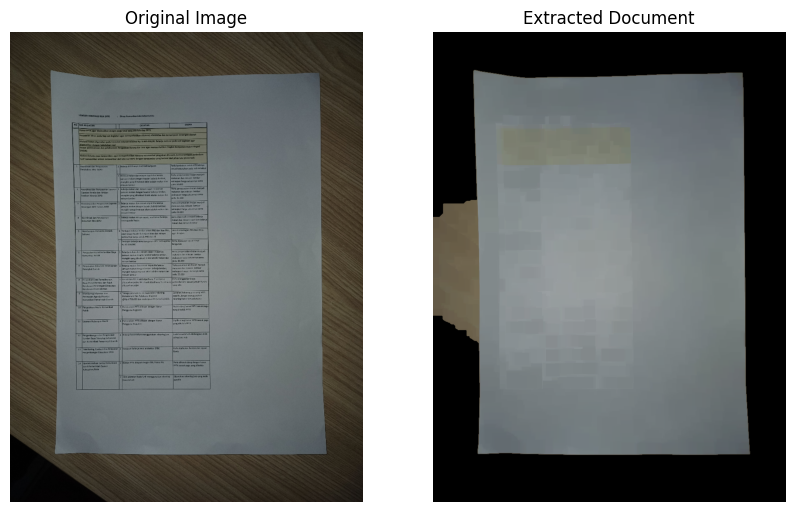

In [24]:
plt.figure(figsize = (10,7))
plt.subplot(1,2,1)
plt.imshow(orig_img[:,:,::-1])
plt.title('Original Image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(result[:,:,::-1])
plt.title('Extracted Document')
plt.axis('off')

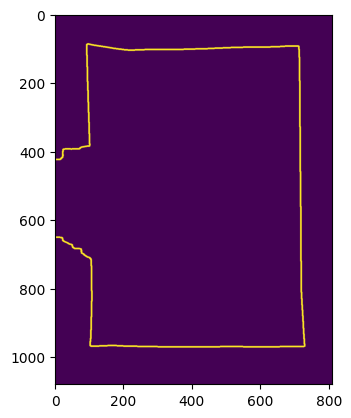

In [25]:
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (11, 11), 0)
# Edge Detection.
canny = cv2.Canny(gray, 100, 200)
canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)))
plt.imshow(canny)

In [26]:
# Blank canvas.
con = np.zeros_like(img)
# Finding contours for the detected edges.
contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
# Keeping only the largest detected contour.
page = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
con = cv2.drawContours(con, page, -1, (0, 255, 255), 3)

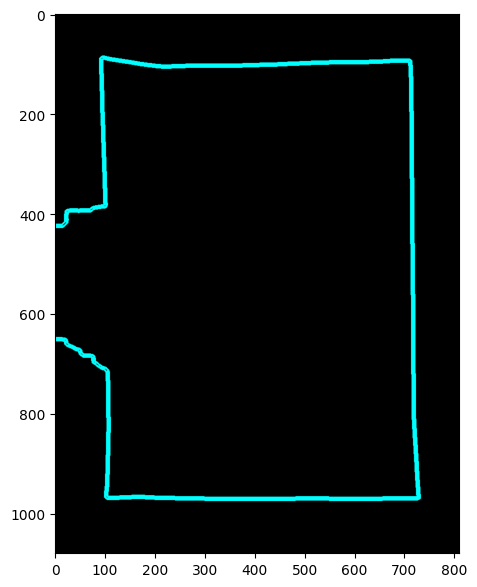

In [27]:
plt.figure(figsize = (10,7))
plt.imshow(con)
plt.show()

In [28]:
def order_points(pts):
	'''Rearrange coordinates to order: 
       top-left, top-right, bottom-right, bottom-left'''
	rect = np.zeros((4, 2), dtype='float32')
	pts = np.array(pts)
	s = pts.sum(axis=1)
	# Top-left point will have the smallest sum.
	rect[0] = pts[np.argmin(s)]
    # Bottom-right point will have the largest sum.
	rect[2] = pts[np.argmax(s)]
	
	diff = np.diff(pts, axis=1)
    # Top-right point will have the smallest difference.
	rect[1] = pts[np.argmin(diff)]
    # Bottom-left will have the largest difference.
	rect[3] = pts[np.argmax(diff)]
	# Return the ordered coordinates.
	return rect.astype('int').tolist()




[[92, 86], [712, 93], [729, 970], [100, 968]]


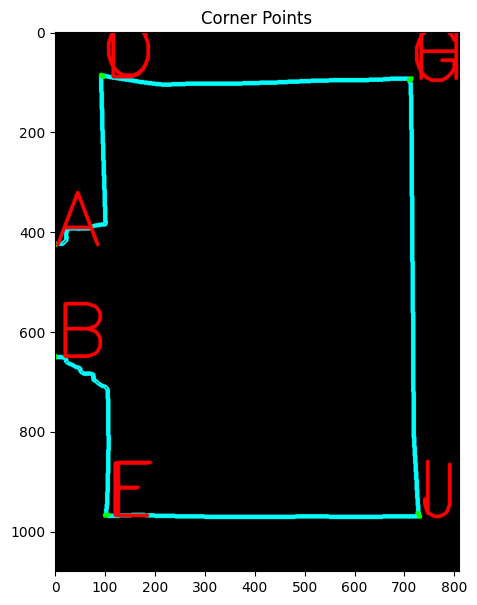

In [29]:
# Blank canvas.
con = np.zeros_like(img)
# Loop over the contours.
for c in page:
	# Approximate the contour.
	epsilon = 0.02 * cv2.arcLength(c, True)
	corners = cv2.approxPolyDP(c, epsilon, True)
	# If our approximated contour has four points
	if len(corners) == 4:
		break

cv2.drawContours(con, c, -1, (0, 255, 255), 3)
cv2.drawContours(con, corners, -1, (0, 255, 0), 10)
# Sorting the corners and converting them to desired shape.
corners = sorted(np.concatenate(corners).tolist())

# Displaying the corners.
for index, c in enumerate(corners):
    character = chr(65 + index)
    cv2.putText(con, character, tuple(c), cv2.FONT_HERSHEY_SIMPLEX, 5, (255, 0, 0), 5, cv2.LINE_AA)

# Rearranging the order of the corner points.
corners = order_points(corners)

print(corners)

plt.figure(figsize = (10,7))
plt.imshow(con)
plt.title('Corner Points')
plt.show()

In [30]:
(tl, tr, br, bl) = corners
# Finding the maximum width.
widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
maxWidth = max(int(widthA), int(widthB))

# Finding the maximum height.
heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
maxHeight = max(int(heightA), int(heightB))
# Final destination co-ordinates.
destination_corners = [
		[0, 0],
		[maxWidth, 0],
		[maxWidth, maxHeight],
		[0, maxHeight]]
print(destination_corners)

[[0, 0], [629, 0], [629, 882], [0, 882]]


In [31]:
# Getting the homography.
homography = cv2.getPerspectiveTransform(np.float32(corners), np.float32(destination_corners))
# Perspective transform using homography.
final = cv2.warpPerspective(orig_img, np.float32(homography), (maxWidth, maxHeight), flags=cv2.INTER_LINEAR)
# cv2.imwrite('grabcutop/img22.jpg', final)

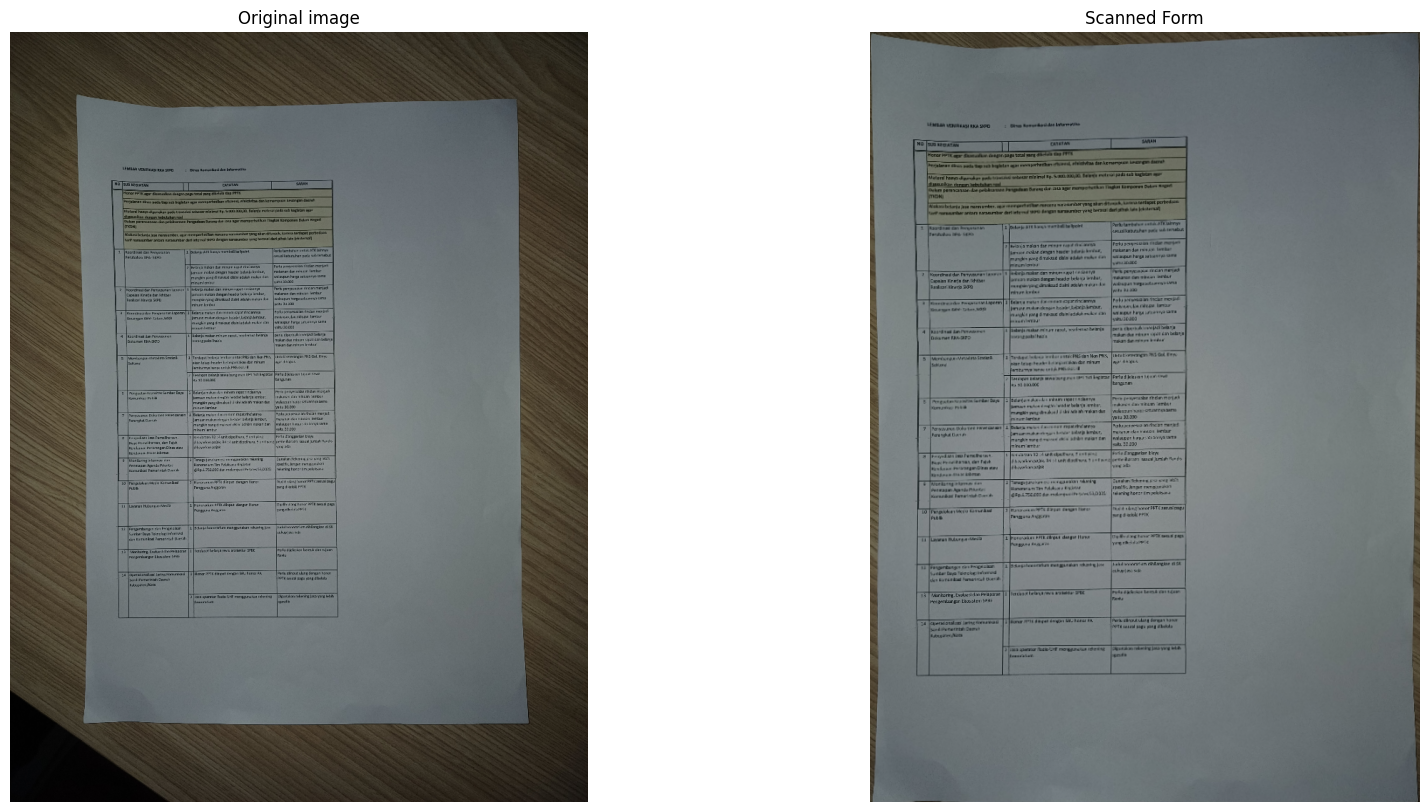

In [32]:
# Display results 
plt.figure(figsize=[20,10]); 
plt.subplot(121); plt.imshow(orig_img[:,:,::-1]); plt.axis('off'); plt.title("Original image")
plt.subplot(122); plt.imshow(final[:,:,::-1]); plt.axis('off'); plt.title("Scanned Form");